Импортируем необходимые библиотеки

In [ ]:
import torch
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

Проверяем доступность графического процессора

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Загружаем датасет для вывода необработанной картинки

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29451298.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Картинка без обработки

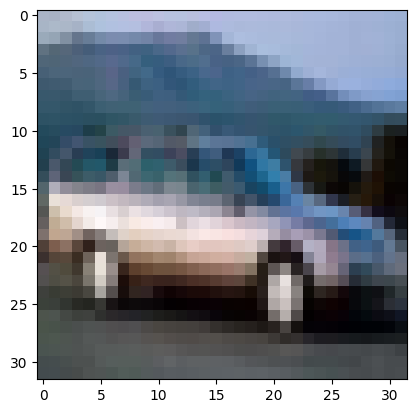

In [ ]:
image, label = train_dataset[4]

plt.imshow(image)
plt.show()

Определяем как трансформировать картинку при загрузке

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [ ]:
batch_size = 128

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
# выводим информацию о датасете
print("Размер тренировочного датасета: ", len(train_dataset))
print("Размер тестового датасета: ", len(test_dataset))
print("Размер батча: ", batch_size)

# определяем количество классов
num_classes = len(train_dataset.classes)
print("Количество классов: ", num_classes)

# определяем диапазон значений пикселей
pixel_min = train_dataset.data.min()
pixel_max = train_dataset.data.max()
print("Минимальное значение пикселя: ", pixel_min)
print("Максимальное значение пикселя: ", pixel_max)

# определяем тип данных пикселей
pixel_type = train_dataset.data.dtype
print("Тип данных пикселей: ", pixel_type)

Размер тренировочного датасета:  50000
Размер тестового датасета:  10000
Размер батча:  128
Количество классов:  10
Минимальное значение пикселя:  0
Максимальное значение пикселя:  255
Тип данных пикселей:  uint8


Картинка полсе загрузки с форматированием

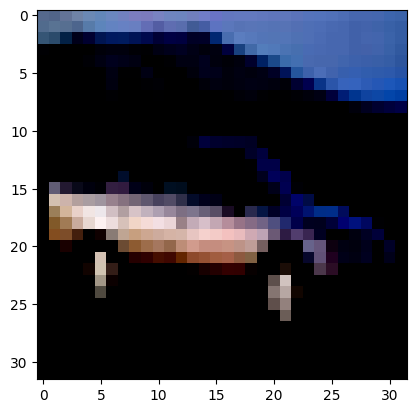

In [ ]:
image, label = train_dataset[4]

plt.imshow(image.permute(1, 2, 0))
plt.show()

Классы, представленные в датасете

In [ ]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Первая модель

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [ ]:
net = Net().cuda()

In [ ]:
net

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

Обучение модели

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0150, acc: 0.3114 
test_loss: 0.0133, test_acc: 0.3834 
epoch:  2
training_loss: 0.0128, acc: 0.4063 
test_loss: 0.0122, test_acc: 0.4240 
epoch:  3
training_loss: 0.0119, acc: 0.4467 
test_loss: 0.0115, test_acc: 0.4631 
epoch:  4
training_loss: 0.0114, acc: 0.4717 
test_loss: 0.0111, test_acc: 0.4776 
epoch:  5
training_loss: 0.0110, acc: 0.4929 
test_loss: 0.0108, test_acc: 0.4958 
epoch:  6
training_loss: 0.0107, acc: 0.5085 
test_loss: 0.0104, test_acc: 0.5128 
epoch:  7
training_loss: 0.0103, acc: 0.5247 
test_loss: 0.0103, test_acc: 0.5195 
epoch:  8
training_loss: 0.0101, acc: 0.5398 
test_loss: 0.0100, test_acc: 0.5323 
epoch:  9
training_loss: 0.0098, acc: 0.5539 
test_loss: 0.0098, test_acc: 0.5488 
epoch:  10
training_loss: 0.0095, acc: 0.5664 
test_loss: 0.0095, test_acc: 0.5563 
epoch:  11
training_loss: 0.0093, acc: 0.5776 
test_loss: 0.0094, test_acc: 0.5591 
epoch:  12
training_loss: 0.0091, acc: 0.5869 
test_loss: 0.0091, test_acc: 0.5748 
e

График изменения значения ошибки

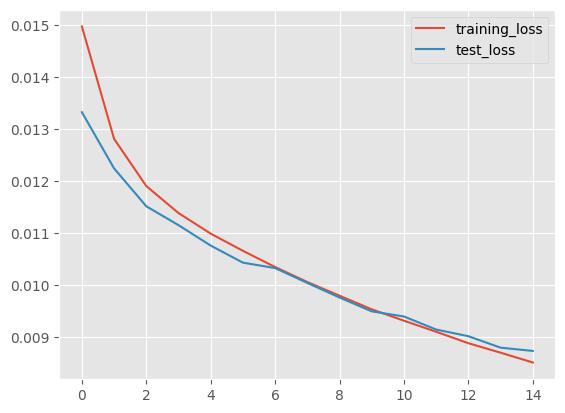

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

График изменения accuracy

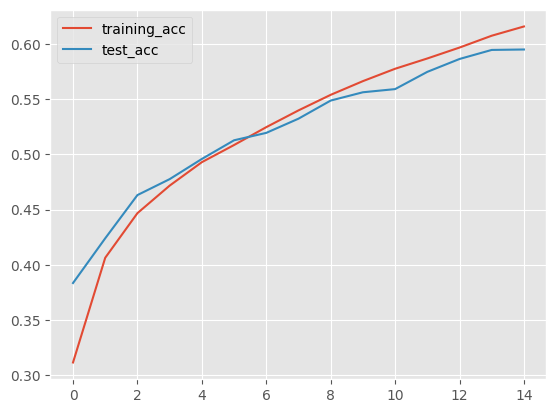

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

Вывод accuracy для каждого класса в датасете

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

Accurace of airplane : 59 %
Accurace of automobile : 84 %
Accurace of  bird : 50 %
Accurace of   cat : 47 %
Accurace of  deer : 37 %
Accurace of   dog : 55 %
Accurace of  frog : 84 %
Accurace of horse : 61 %
Accurace of  ship : 71 %
Accurace of truck : 42 %



Вторая модель

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*128, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = x.view(-1, 4*4*128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = Net().cuda()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

Обучение модели

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0156, acc: 0.2579 
test_loss: 0.0137, test_acc: 0.3435 
epoch:  2
training_loss: 0.0130, acc: 0.3813 
test_loss: 0.0125, test_acc: 0.3996 
epoch:  3
training_loss: 0.0120, acc: 0.4308 
test_loss: 0.0118, test_acc: 0.4362 
epoch:  4
training_loss: 0.0115, acc: 0.4608 
test_loss: 0.0111, test_acc: 0.4665 
epoch:  5
training_loss: 0.0111, acc: 0.4806 
test_loss: 0.0107, test_acc: 0.4880 
epoch:  6
training_loss: 0.0107, acc: 0.5002 
test_loss: 0.0104, test_acc: 0.5065 
epoch:  7
training_loss: 0.0104, acc: 0.5158 
test_loss: 0.0103, test_acc: 0.5113 
epoch:  8
training_loss: 0.0100, acc: 0.5335 
test_loss: 0.0100, test_acc: 0.5245 
epoch:  9
training_loss: 0.0098, acc: 0.5472 
test_loss: 0.0097, test_acc: 0.5450 
epoch:  10
training_loss: 0.0095, acc: 0.5559 
test_loss: 0.0097, test_acc: 0.5436 
epoch:  11
training_loss: 0.0093, acc: 0.5695 
test_loss: 0.0092, test_acc: 0.5667 
epoch:  12
training_loss: 0.0090, acc: 0.5835 
test_loss: 0.0092, test_acc: 0.5691 
e

График изменения значения ошибки

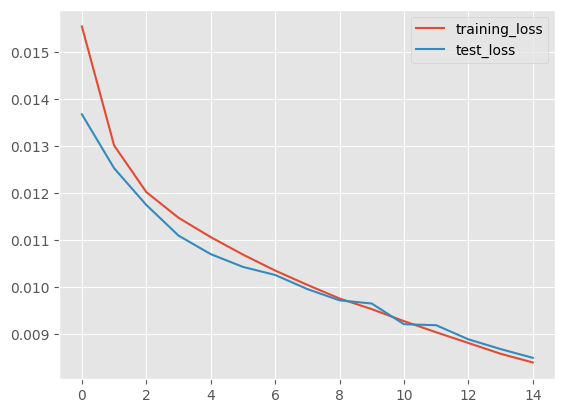

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

График изменения accuracy 

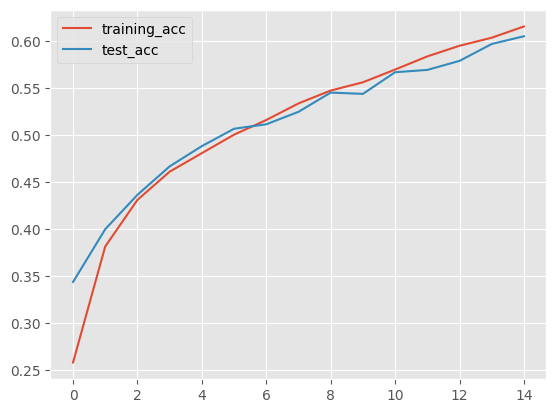

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

Вывод значения accuracy для каждого класса датасета

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

Accurace of airplane : 65 %
Accurace of automobile : 78 %
Accurace of  bird : 53 %
Accurace of   cat : 72 %
Accurace of  deer : 56 %
Accurace of   dog : 44 %
Accurace of  frog : 68 %
Accurace of horse : 70 %
Accurace of  ship : 92 %
Accurace of truck : 70 %



Третья модель

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(512, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 10)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [ ]:
net = Net().cuda()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
test_running_loss_history = []
test_running_corrects_history = []

In [ ]:
for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  test_running_loss = 0.0
  test_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  with torch.no_grad():
    for test_inputs, test_labels in test_loader:
      test_inputs = test_inputs.cuda()
      test_labels = test_labels.cuda()
      test_outputs = net(test_inputs)
      test_loss = loss_function(test_outputs, test_labels)

      _, test_preds = torch.max(test_outputs, 1)
      test_running_loss += test_loss.item()
      test_running_corrects += torch.sum(test_preds == test_labels.data)

  epoch_loss = running_loss/(len(train_loader)*batch_size)
  epoch_acc = running_corrects.float()/(len(train_loader)*batch_size)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  test_epoch_loss = test_running_loss/(len(test_loader)*batch_size)
  test_epoch_acc = test_running_corrects.float()/(len(test_loader)*batch_size)
  test_running_loss_history.append(test_epoch_loss)
  test_running_corrects_history.append(test_epoch_acc.cpu().numpy())

  print('epoch: ', e+1)
  print('training_loss: {:.4f}, acc: {:.4f} '.format(epoch_loss, epoch_acc.item()))
  print('test_loss: {:.4f}, test_acc: {:.4f} '.format(test_epoch_loss, test_epoch_acc.item()))

epoch:  1
training_loss: 0.0103, acc: 0.5145 
test_loss: 0.0077, test_acc: 0.6437 
epoch:  2
training_loss: 0.0065, acc: 0.7083 
test_loss: 0.0063, test_acc: 0.7149 
epoch:  3
training_loss: 0.0048, acc: 0.7869 
test_loss: 0.0059, test_acc: 0.7395 
epoch:  4
training_loss: 0.0037, acc: 0.8375 
test_loss: 0.0055, test_acc: 0.7583 
epoch:  5
training_loss: 0.0028, acc: 0.8799 
test_loss: 0.0052, test_acc: 0.7802 
epoch:  6
training_loss: 0.0021, acc: 0.9074 
test_loss: 0.0056, test_acc: 0.7753 
epoch:  7
training_loss: 0.0016, acc: 0.9323 
test_loss: 0.0064, test_acc: 0.7738 
epoch:  8
training_loss: 0.0013, acc: 0.9453 
test_loss: 0.0063, test_acc: 0.7826 
epoch:  9
training_loss: 0.0010, acc: 0.9574 
test_loss: 0.0068, test_acc: 0.7855 
epoch:  10
training_loss: 0.0009, acc: 0.9616 
test_loss: 0.0064, test_acc: 0.7850 
epoch:  11
training_loss: 0.0007, acc: 0.9682 
test_loss: 0.0073, test_acc: 0.7797 
epoch:  12
training_loss: 0.0007, acc: 0.9705 
test_loss: 0.0071, test_acc: 0.7981 
e

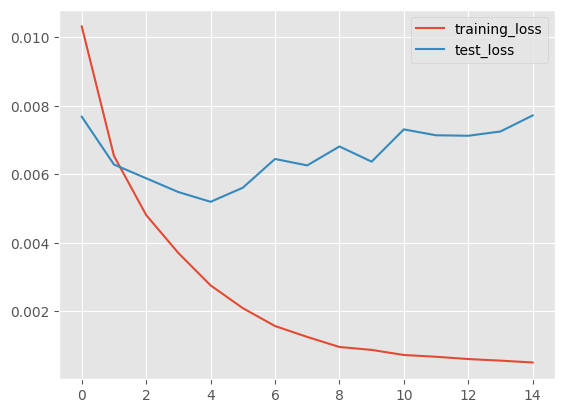

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label = 'training_loss')
plt.plot(test_running_loss_history, label = 'test_loss')
plt.legend()

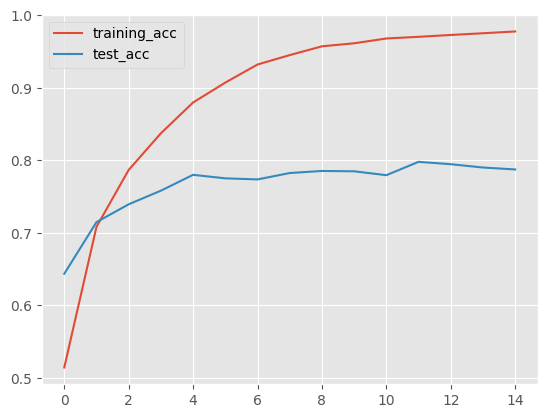

In [ ]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training_acc')
plt.plot(test_running_corrects_history, label='test_acc')
plt.legend()

In [ ]:
correct = 0
total = 0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

for i in range(10):
  print("Accurace of %5s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

print()

Accurace of airplane : 92 %
Accurace of automobile : 94 %
Accurace of  bird : 75 %
Accurace of   cat : 75 %
Accurace of  deer : 86 %
Accurace of   dog : 57 %
Accurace of  frog : 70 %
Accurace of horse : 76 %
Accurace of  ship : 84 %
Accurace of truck : 86 %



Вывод результатов обучения из всех трех файлов (данные вбивал вручную)

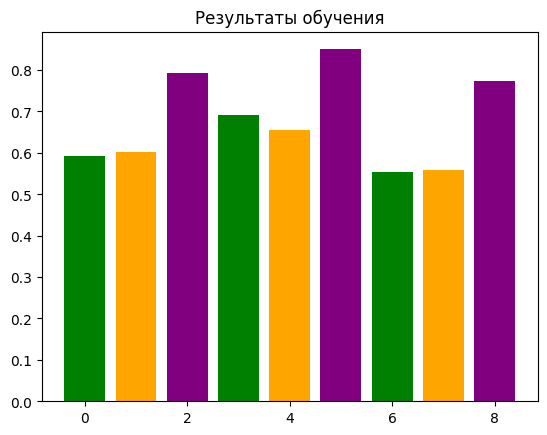

In [ ]:
data = np.array([[0.5909], [0.6013], [0.7933], [0.6909], [0.6552], [0.8496], [0.5536], [0.5583], [0.7727]])

colors = ['green' if i in [0, 3, 6] else 'orange' if i in [1, 4, 7] else 'purple' for i in range(len(data))]

plt.bar(range(len(data)), data.flatten(), color=colors)

plt.title('Результаты обучения')

plt.show()